### 0. Import libraries

In [76]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

## 1. Define model

In [125]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        print(hidden_size,self.hidden_size,type(hidden_size),type(self.hidden_size))
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size + static_feature_size, hidden_size)  
        self.relu = nn.ReLU() 
        
        # Second Fully connected layer
        self.fc2 = nn.Linear(hidden_size, 3)
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
         # Pass concatenated features through first fully connected layer
        x = self.relu(self.fc1(concatenated_features))  

        # Pass through the second fully connected layer
        output = self.fc2(x)

        return output

## 2. Define training class


In [126]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        self.loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        #self.loss_fn = nn.KLDivLoss(reduction='batchmean')
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.learning_rate = learning_rate
    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        #print(x_dynamic.shape,x_static.shape,y_true.shape,y_pred.shape)
        #print(x_dynamic[0,0,0],x_static[0,0],y_true[0,0],y_pred[0,0])
        #print(type(x_dynamic[0,0,0]),type(x_static[0,0]), type(y_true[0,0]), type(y_pred[0,0]))
        #print(self.loss_fn)
        #if self.loss_fn == "KLDivLoss()":
        #y_pred= - nn.functional.log_softmax(y_pred,dim=-1)     # softmax(y_pred, dim=-1)  
        print(y_pred)
        #    print('KL')

        loss = self.loss_fn(y_pred.float(), y_true.float())  
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss
    """"
    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
        val_loss = self.loss_fn(y_pred_log, y_true)
        self.log('val_loss', val_loss)
        self.validation_losses.append(val_loss.item())
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
        test_loss = self.loss_fn(y_pred_log, y_true)
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        return test_loss
    """
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [79]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import ast

class SolarPanelDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file, converters={
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian': ast.literal_eval
        })
        
        # Label encoding for categorical variables
        self.encoder_panel = LabelEncoder()
        self.encoder_module = LabelEncoder()
        self.data_frame['panel_type'] = self.encoder_panel.fit_transform(self.data_frame['panel_type'])
        self.data_frame['module_type'] = self.encoder_module.fit_transform(self.data_frame['module_type'])

        # Normalize static and dynamic features
        self.normalize_features()

        # Normalize outputs and store normalization parameters
        self.output_means = []
        self.output_stds = []
        self.normalize_outputs()

    def normalize_features(self):
        # Normalize static numeric features
        for feature in ['tilt', 'azimuth']:
            mean = self.data_frame[feature].mean()
            std = self.data_frame[feature].std()
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            std = col_data.std()
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  # Set all to zero

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        gaussian_array = np.array(self.data_frame['gaussian'].tolist())
        self.output_mins = gaussian_array.min(axis=0)
        self.output_maxs = gaussian_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (gaussian_array - self.output_mins) / range
        self.data_frame['gaussian'] = list(normalized_gaussian)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['panel_type', 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features 
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, normalized
        outputs = torch.tensor(self.data_frame.iloc[idx]['gaussian'])

        return dynamic_features, static_features, outputs

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output.numpy() * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output

# Example usage
dataset = SolarPanelDataset('energy_data/model_input.csv')
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

for i, data in enumerate(data_loader):
    if i > 10:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # Gaussian: Amplitude, Mean, standard deviation (normalized)

    # Example to denormalize the output for the first batch
    #if i == 0:
    #    denormalized_outputs = [dataset.denormalize_output(output) for output in outputs]
    #     print("Denormalized Outputs:", denormalized_outputs)


Static Inputs: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Dynamic Inputs Shape: torch.Size([10, 24, 5])
Outputs: tensor([[0.8530, 0.3981, 0.6052],
        [0.0970, 0.4156, 0.3636],
        [0.4241, 0.4409, 0.7624],
        [0.4846, 0.3825, 0.8503],
        [0.0570, 0.4894, 0.4415],
        [0.5623, 0.6886, 0.1808],
        [0.1390, 0.3728, 0.7522],
        [0.0703, 0.6133, 0.4007],
        [0.4406, 0.3947, 0.0658],
        [0.2022, 0.3447, 0.2273]], dtype=torch.float64)
Static Inputs: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Dynamic Inputs Shape: torch.Siz

## 4. Train model

In [80]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 4
hidden_size = 128
learning_rate = 1e-2

# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate)
model = train_module.model 
print(model)
#print(summary(model, [(dynamic_feature_size,), (static_feature_size,)]))

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=10, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 86.5 K
1 | loss_fn | KLDivLoss             | 0     
--------------------------------------------------
86.5 K    Trainable params
0         Non-trainable params
86.5 K    Total params
0.346     Total estimated model params size (MB)


128 128 <class 'int'> <class 'int'>
EnergyPredictionModel(
  (dynamic_rnn): LSTM(5, 128, batch_first=True)
  (fc1): Linear(in_features=132, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Log directory contents: ['version_10', 'version_11', 'version_12', 'version_13', 'version_14', 'version_15', 'version_16', 'version_17', 'version_18', 'version_19', 'version_20', 'version_21', 'version_22', 'version_23', 'version_24', 'version_25', 'version_26', 'version_27', 'version_28', 'version_29', 'version_30', 'version_31', 'version_32', 'version_33', 'version_34', 'version_35', 'version_36', 'version_37', 'version_38', 'version_39', 'version_40', 'version_41', 'version_42', 'version_43', 'version_44', 'version_45', 'version_46', 'version_47', 'version_48', 'version_49', 'version_50', 'version_51', 'version_52', 'version_53', 'version_54', 'version_55', 'version_56', 'version_57', 'version_58', 'version_59', 'version_6', 'version_60', 

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

tensor([[1.0110, 1.1007, 1.1923],
        [1.0078, 1.1060, 1.1904],
        [1.0110, 1.1013, 1.1917],
        [1.0175, 1.0975, 1.1881],
        [1.0161, 1.0964, 1.1910],
        [1.0145, 1.0989, 1.1901],
        [1.0100, 1.1028, 1.1913],
        [1.0065, 1.1023, 1.1960],
        [1.0158, 1.0978, 1.1898],
        [1.0102, 1.1019, 1.1921]], grad_fn=<NegBackward0>)
tensor([[1.1298, 1.0331, 1.1362],
        [1.1445, 1.0388, 1.1156],
        [1.1470, 1.0443, 1.1073],
        [1.1565, 1.0846, 1.0574],
        [1.1596, 1.1058, 1.0344],
        [1.1348, 1.0058, 1.1623],
        [1.1762, 1.1377, 0.9916],
        [1.1881, 1.1329, 0.9860],
        [1.1706, 1.1291, 1.0038],
        [1.1756, 1.0333, 1.0921]], grad_fn=<NegBackward0>)
tensor([[1.2146, 0.8931, 1.2249],
        [1.2553, 0.8405, 1.2604],
        [1.1921, 0.9305, 1.1971],
        [1.2841, 0.8311, 1.2464],
        [1.3539, 0.7388, 1.3315],
        [1.3448, 0.7485, 1.3230],
        [1.2855, 0.8267, 1.2519],
        [1.1729, 1.0051, 1.1253]

`Trainer.fit` stopped: `max_epochs=10` reached.


tensor([[468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500],
        [468197.5938,     -0.0000, 470146.7500]], grad_fn=<NegBackward0>)
tensor([[470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.5000],
        [470912.5625,     -0.0000, 472871.50

## 5. Inspect performance

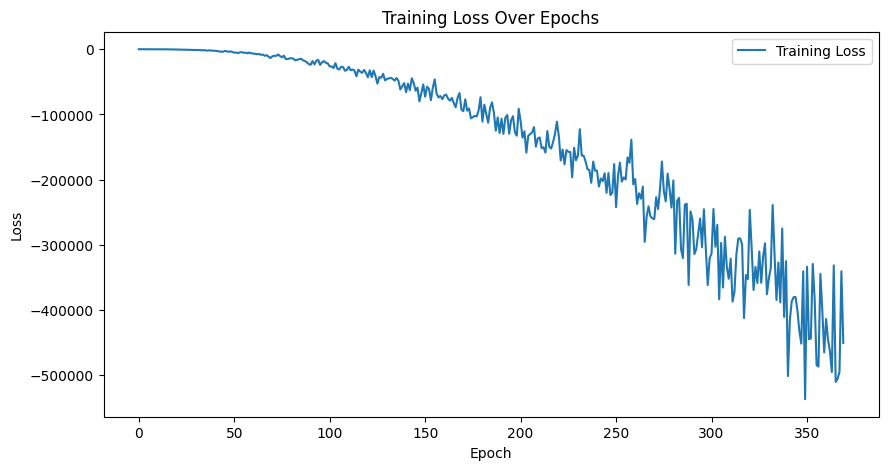

-2.4223761558532715
-2.3580732345581055
-2.4865775108337402
-2.6346774101257324
-7.166735649108887
-15.809844970703125
-16.3569393157959
-33.26022720336914
-46.2290153503418
-58.15128707885742
-76.89916229248047
-109.87088775634766
-88.59736633300781
-168.05770874023438
-120.5301284790039
-161.3785858154297
-182.51889038085938
-267.1304016113281
-302.2842102050781
-411.9825744628906
-489.02947998046875
-532.6431274414062
-761.2096557617188
-567.1952514648438
-707.8348388671875
-799.4132080078125
-895.5081176757812
-1000.4000244140625
-1187.78857421875
-1102.0462646484375
-1369.412841796875
-1253.575927734375
-1117.479736328125
-1705.2767333984375
-1500.575439453125
-1750.4765625
-2184.866943359375
-1632.297119140625
-2150.42529296875
-2314.0400390625
-2401.108642578125
-2836.729248046875
-3315.928955078125
-3736.89111328125
-3951.51220703125
-2644.463134765625
-3137.43896484375
-3935.405029296875
-3319.536376953125
-4141.1611328125
-5207.802734375
-5105.57666015625
-5994.3193359375
-46

In [129]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

for i in  train_module.train_losses:
    print(i)


## 5. Evaluate model

In [89]:
#Launch tensorboard for advanced training insights.
os.system(f"taskkill /pid 19988 /F")

# Reload the TensorBoard extension to avoid errors about it being already loaded
%reload_ext tensorboard

# Start TensorBoard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6007 (pid 19988), started 8 days, 20:23:23 ago. (Use '!kill 19988' to kill it.)

### Use model

tensor([[-244967.8125,  248088.9062, -247021.1250]]) torch.Size([1, 3])
[[-244967.81  248088.9  -247021.12]] (1, 3)


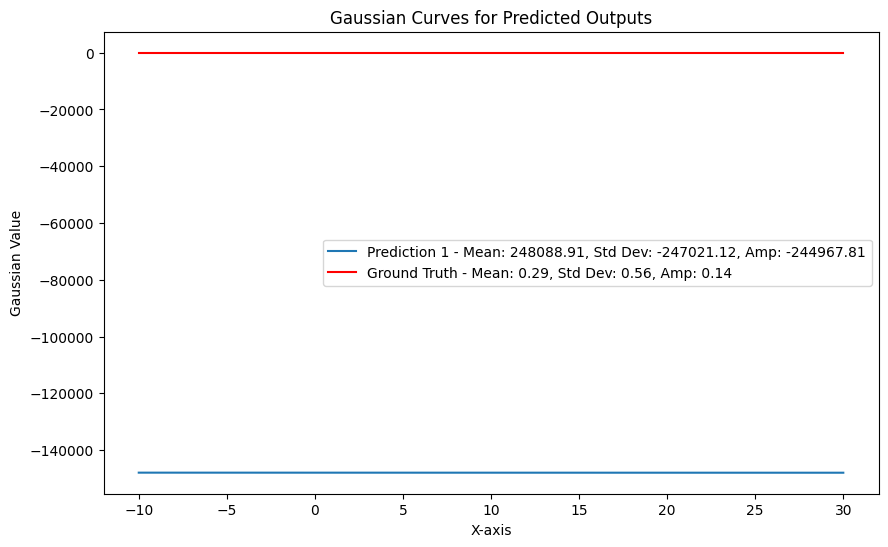

In [131]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(data_loader))
sample =5
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-10, 30, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])